In [27]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

In [78]:
def data_loading():
    """
    This function loads the training and test data, preprocesses it, removes the NaN values and interpolates the missing
    data using imputation

    Parameters
    ----------
    Returns
    ----------
    X_train: matrix of floats, training input with features
    y_train: array of floats, training output with labels
    X_test: matrix of floats: dim = (100, ?), test input with features
    """
    # Load training data
    train_df = pd.read_csv("train.csv")

    # print("Training data:")
    # print("Shape:", train_df.shape)
    # print(train_df.head(2))
    # print('\n')

    # Load test data
    test_df = pd.read_csv("test.csv")

    # print("Test data:")
    # print(test_df.shape)
    # print(test_df.head(2))

    # # Dummy initialization of the X_train, X_test and y_train
    # X_train = np.zeros_like(train_df.drop(['price_CHF'], axis=1))
    # y_train = np.zeros_like(train_df['price_CHF'])
    # X_test = np.zeros_like(test_df)

    # print(train_df)

    # Perform data preprocessing, imputation and extract X_train, y_train and X_test using mean values

    # Use interpolation for missing values. Interpolate cannot handle missing starting or end values. So fill these up with mean()

    # Why does this not work with RBF?
    
    ### Training set

    new_train_df = train_df.interpolate(method="akima")
    new_train_df = new_train_df.fillna(train_df.mean())

    # Encode season data

    binary_version_seasons = pd.get_dummies(new_train_df['season'])
    new_train_df = new_train_df.drop(columns=['season']).join(binary_version_seasons)

    y_train = new_train_df["price_CHF"]
    X_train = new_train_df.drop(columns=["price_CHF"])

    ### Test set

    new_test_df = test_df.interpolate(method="akima")
    new_test_df = new_test_df.fillna(new_test_df.mean())

    # Encode season data

    new_test_df = new_test_df.drop(columns=['season']).join(binary_version_seasons)

    X_test = new_test_df

    

    assert (X_train.shape[1] == X_test.shape[1]) and (X_train.shape[0] == y_train.shape[0]) and (
                X_test.shape[0] == 100), "Invalid data shape"
    return X_train, y_train, X_test

In [65]:
X_train, y_train, X_test = data_loading()

/tmp/ipykernel_544855/637515153.py:45: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  new_train_df = new_train_df.fillna(train_df.mean())
/tmp/ipykernel_544855/637515153.py:58: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  new_test_df = new_test_df.fillna(new_test_df.mean())


In [66]:
# X_train = X_train.drop(columns='season')
# X_test = X_test.drop(columns='season')

KeyError: "['season'] not found in axis"

In [67]:
X_train.head()

,price_AUS,price_CZE,price_GER,price_ESP,price_FRA,price_UK,price_ITA,price_POL,price_SVK,autumn,spring,summer,winter
0,-0.665411,-1.686248,-1.748076,-3.666005,-2.914028,-1.822720,-3.931031,-0.296811,-3.238197,0,1,0,0
1,-0.665411,-2.132377,-2.054363,-3.295697,-4.104759,-1.826021,-4.033859,-0.296811,-3.212894,0,0,1,0
2,-2.101937,-1.910282,-1.828418,-3.388777,-4.043980,-2.034409,-4.073850,-0.296811,-3.114061,1,0,0,0
3,-2.098475,-1.903834,-1.556678,-3.588235,-3.978186,-2.214720,-4.018620,-2.330803,-2.963840,0,0,0,1
4,-1.969687,-1.697257,-1.331049,-3.733160,-3.911096,-2.388092,-4.093946,-2.217360,-2.796754,0,1,0,0


In [68]:
y_train.head()

0    9.644028
1    7.246061
2    7.620085
3    8.411894
4    8.926884
Name: price_CHF, dtype: float64

In [69]:
X_test.head()

,price_AUS,price_CZE,price_GER,price_ESP,price_FRA,price_UK,price_ITA,price_POL,price_SVK,autumn,spring,summer,winter
0,-1.330600,0.472985,0.707957,-4.009095,-1.136441,-0.596703,-3.304914,3.298693,1.921886,0,1,0,0
1,-1.184837,0.358019,0.741609,-3.199028,-1.069695,-0.579515,-1.420091,3.238307,1.972984,0,0,1,0
2,-1.116459,0.354504,0.780460,-3.338948,-1.053149,-0.586339,-1.331542,3.207398,2.020570,1,0,0,0
3,-1.090106,0.353066,0.833429,-3.287990,-1.322626,-0.628873,-1.304240,3.159858,2.064163,0,0,0,1
4,-1.073283,0.269644,0.771367,-3.245495,-1.362051,-0.717914,-1.341538,3.205007,2.101199,0,1,0,0


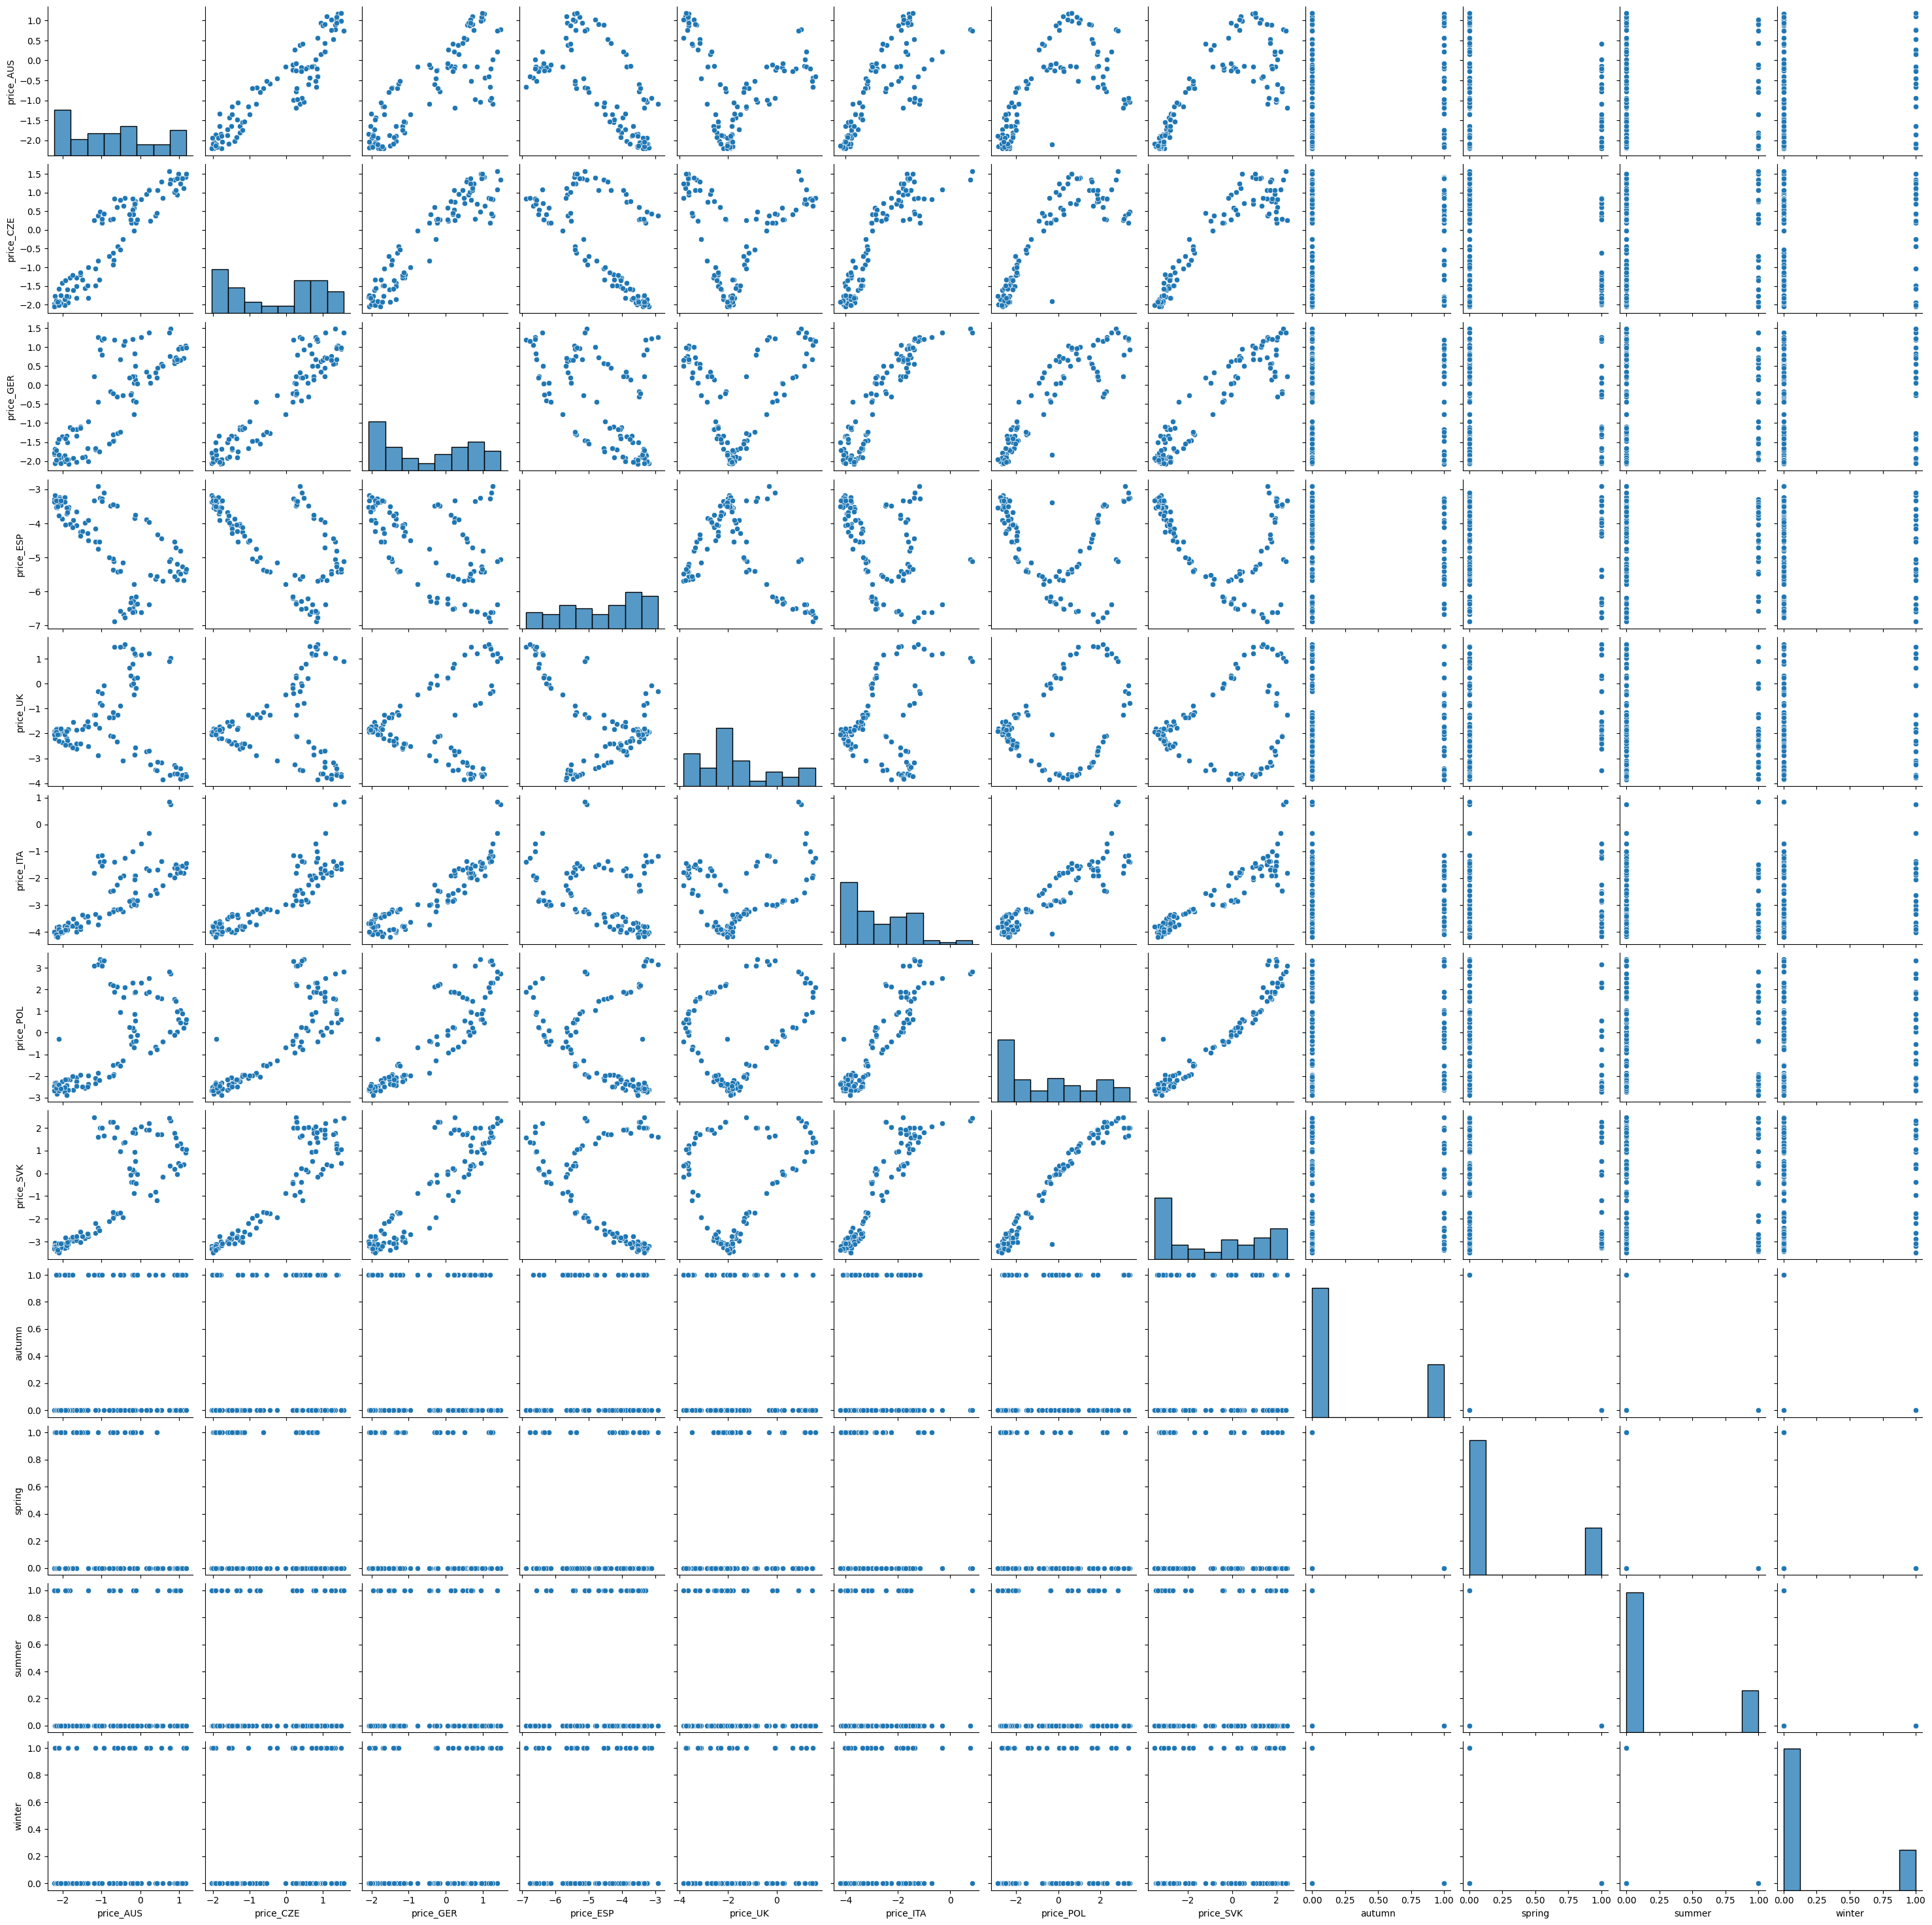

In [71]:
sns.pairplot(X_train.sample(n=100)[['price_AUS', 'price_CZE', 'price_GER', 'price_ESP', 'price_UK', 'price_ITA', 'price_POL', 'price_SVK', 'autumn', 'spring', 'summer', 'winter']])

In [75]:
#--------MODEL BUILDING
num_params = len(X_train.keys())
print(num_params)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer([num_params], name="Input_Layer"),
    tf.keras.layers.Dense(50, activation='relu', name="dense_01"),
    tf.keras.layers.Dense(50, activation='relu', name="dense_02"),
    # 1 node in the output for the median_house_vale
    tf.keras.layers.Dense(1, name="Output_Layer")
  ])

learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate),
              # loss function to minimize
              loss=tf.keras.losses.MeanSquaredError(),
              # list of metrics to monitor
              metrics=['mae',])

model.summary()

13
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_01 (Dense)            (None, 50)                700       
                                                                 
 dense_02 (Dense)            (None, 50)                2550      
                                                                 
 Output_Layer (Dense)        (None, 1)                 51        
                                                                 
Total params: 3,301
Trainable params: 3,301
Non-trainable params: 0
_________________________________________________________________


In [76]:
# FIT/TRAIN model on training data
history = model.fit(X_train, y_train,
                    batch_size=20,
                    epochs=100,
                    validation_split=0.2,
                    # validation_data=X_test,
                    verbose=1)

Epoch 1/100
36/36 [==============================] - 0s 5ms/step - loss: 36.9557 - mae: 5.4310 - val_loss: 36.8862 - val_mae: 5.6053
Epoch 2/100
36/36 [==============================] - 0s 3ms/step - loss: 29.9336 - mae: 4.8306 - val_loss: 29.6581 - val_mae: 4.9172
Epoch 3/100
36/36 [==============================] - 0s 3ms/step - loss: 24.2546 - mae: 4.2735 - val_loss: 23.3768 - val_mae: 4.2197
Epoch 4/100
36/36 [==============================] - 0s 3ms/step - loss: 19.4058 - mae: 3.7376 - val_loss: 18.1686 - val_mae: 3.5634
Epoch 5/100
36/36 [==============================] - 0s 3ms/step - loss: 15.4473 - mae: 3.2353 - val_loss: 13.9146 - val_mae: 3.0097
Epoch 6/100
36/36 [==============================] - 0s 3ms/step - loss: 12.0258 - mae: 2.8113 - val_loss: 10.3979 - val_mae: 2.5920
Epoch 7/100
36/36 [==============================] - 0s 3ms/step - loss: 9.0988 - mae: 2.4256 - val_loss: 7.5228 - val_mae: 2.2225
Epoch 8/100
36/36 [==============================] - 0s 3ms/step - loss

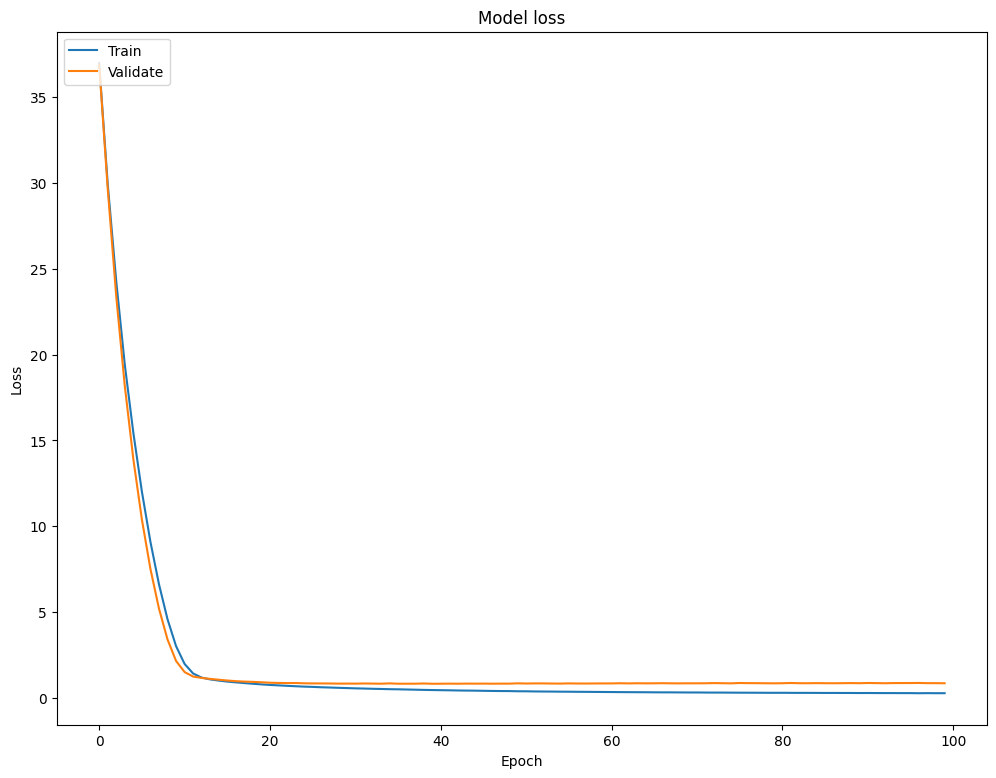

In [77]:
#--------MONITOR
# Plot training & validation loss values
fig = plt.figure(figsize=(12,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()